In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

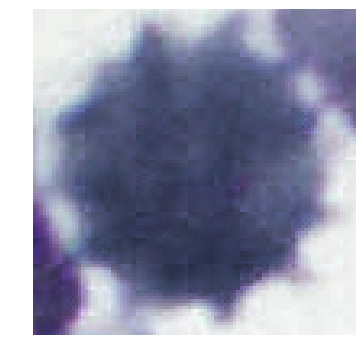

In [2]:
img_dir='/home/poudelas/PycharmProjects/Kam/train-20200327T102929Z-001/train'
hyper_param_epoch = 20
hyper_param_batch = 8
hyper_param_learning_rate = 0.001
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# Example image
x = Image.open(img_dir + '/redblood/cell_0.png')
np.array(x).shape
imshow(x)

In [11]:
class CustomConvNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomConvNet, self).__init__()

        self.layer1 = self.conv_module(3, 64)
        self.layer2 = self.conv_module(64, 128)
        self.layer3 = self.conv_module(128, 256)
        self.layer4 = self.conv_module(256, 256)
        self.layer5 = self.conv_module(256, 512)
        self.gap = self.global_avg_pool(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 4)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))

In [12]:
transforms_train = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

transforms_test = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])

In [13]:
#Loading in the dataset
train_data = datasets.ImageFolder(img_dir,transform=transforms_train)
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=test_sampler, num_workers=num_workers)


1721 861 6025


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = CustomConvNet(num_classes=4).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)


optimizer = optim.Adam(model.parameters(), lr=0.01)
#criterion = nn.CrossEntropyLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
def train(epoch):
    model.train()
    tr_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        # Clearing the Gradients of the model parameters
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output.data, 1)[1]
        correct += (pred == target).sum()
        total += len(data)
        
        # Computing the loss
        loss = criterion(output, target)
        
        # Computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {} %'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(),100 * correct / total))
            torch.save(model.state_dict(), './model.pth')
            torch.save(model.state_dict(), './optimizer.pth')
    train_loss.append(tr_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

In [16]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

In [17]:
n_epochs = 5
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
for epoch in range(n_epochs):
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [3200/8607 (53%)]	Loss: 0.610187 	 Accuracy: 80 %


/home/poudelas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/poudelas/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Validation loss: 0.05336	Accuracy: 89 %
Train Epoch: 1 [3200/8607 (53%)]	Loss: 0.322597 	 Accuracy: 92 %

Average Validation loss: 0.03172	Accuracy: 93 %
Train Epoch: 2 [3200/8607 (53%)]	Loss: 0.104505 	 Accuracy: 93 %

Average Validation loss: 0.02075	Accuracy: 94 %
Train Epoch: 3 [3200/8607 (53%)]	Loss: 0.208268 	 Accuracy: 93 %

Average Validation loss: 0.01960	Accuracy: 93 %
Train Epoch: 4 [3200/8607 (53%)]	Loss: 0.178451 	 Accuracy: 94 %

Average Validation loss: 0.02803	Accuracy: 92 %


In [24]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Train - Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Train - Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , train_accuracy, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_accuracy, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

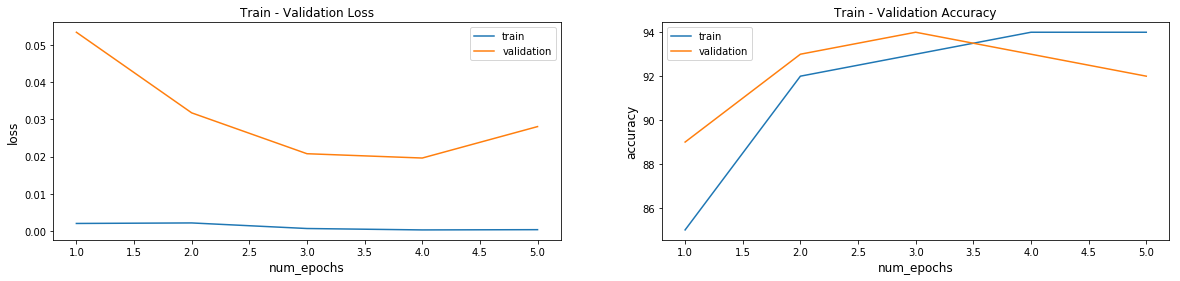

In [25]:
plot_graph(n_epochs)

Acc: 0.56  Loss: 1.3226
Acc: 0.34  Loss: 1.3074
Acc: 0.38  Loss: 1.2849
Acc: 0.41  Loss: 1.3126
Acc: 0.5  Loss: 1.2716
Acc: 0.41  Loss: 1.2802
Acc: 0.56  Loss: 1.1848
Acc: 0.59  Loss: 1.1921
Acc: 0.66  Loss: 1.2248
Acc: 0.75  Loss: 1.1981
Acc: 0.69  Loss: 1.19
Acc: 0.75  Loss: 1.0894
Acc: 0.84  Loss: 1.2108
Acc: 0.69  Loss: 1.1624
Acc: 0.75  Loss: 1.0604
Acc: 0.72  Loss: 1.1158
Acc: 0.72  Loss: 1.0853
Acc: 0.69  Loss: 1.0843
Acc: 0.66  Loss: 1.1186
Acc: 0.75  Loss: 1.0756
Acc: 0.75  Loss: 1.115
Acc: 0.66  Loss: 1.059
Acc: 0.72  Loss: 1.0962
Acc: 0.69  Loss: 1.1078
Acc: 0.75  Loss: 1.04
Acc: 0.69  Loss: 1.072
Acc: 0.69  Loss: 1.0129
Acc: 0.69  Loss: 1.0513
Acc: 0.78  Loss: 1.1345
Acc: 0.81  Loss: 1.0806
Acc: 0.72  Loss: 1.0034
Acc: 0.81  Loss: 1.0644
Acc: 0.78  Loss: 1.1542
Acc: 0.72  Loss: 1.0579
Acc: 0.75  Loss: 1.0316
Acc: 0.81  Loss: 1.0251
Acc: 0.81  Loss: 0.9876
Acc: 0.78  Loss: 1.0777
Acc: 0.81  Loss: 0.9778
Acc: 0.75  Loss: 1.0547
Acc: 0.75  Loss: 1.0466
Acc: 0.84  Loss: 1.0246


Acc: 0.75  Loss: 0.7466
Acc: 0.81  Loss: 0.7666
Acc: 0.75  Loss: 0.7559
Acc: 0.78  Loss: 0.7213
Acc: 0.75  Loss: 0.766
Acc: 0.78  Loss: 0.8185
Acc: 0.78  Loss: 0.7551
Acc: 0.81  Loss: 0.7718
Acc: 0.81  Loss: 0.7734
Acc: 0.84  Loss: 0.7246
Acc: 0.81  Loss: 0.8622
Acc: 0.72  Loss: 0.7405
Acc: 0.78  Loss: 0.739
Acc: 0.81  Loss: 0.7829
Acc: 0.84  Loss: 0.7569
Acc: 0.81  Loss: 0.8088
Acc: 0.84  Loss: 0.8433
Acc: 0.78  Loss: 0.8653
Acc: 0.81  Loss: 0.8523
Acc: 0.78  Loss: 0.7527
Acc: 0.72  Loss: 0.796
Acc: 0.81  Loss: 0.7629
Acc: 0.78  Loss: 0.748
Acc: 0.78  Loss: 0.7594
Acc: 0.84  Loss: 0.7405
Acc: 0.81  Loss: 0.853
Acc: 0.75  Loss: 0.6951
Acc: 0.81  Loss: 0.6984
Acc: 0.88  Loss: 0.8196
Acc: 0.88  Loss: 0.8042
Acc: 0.78  Loss: 0.7607
Acc: 0.78  Loss: 0.814
Acc: 0.88  Loss: 0.7235
Acc: 0.78  Loss: 0.724
Test Accuracy of the model on the 861 test images: 94.3089430894309 %


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pretrained=True will download a pretrained network for us
model1 = models.vgg16(pretrained=True)
model1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [46]:
import torchvision
model1 = torchvision.models.vgg16(pretrained='imagenet')
# Number of filters in the bottleneck layer
num_ftrs = model1.classifier[6].in_features# convert all the layers to list and remove the last one
features = list(model1.classifier.children())[:-1]## Add the last layer based on the num of classes in our dataset
features.extend([nn.Linear(num_ftrs, 4)])## convert it into container and add it to our model class.
model1.classifier = nn.Sequential(*features)

In [47]:
criterion = nn.CrossEntropyLoss()
#Over here we want to only update the parameters of the classifier so
optimizer = torch.optim.Adam(model1.classifier.parameters(), lr=0.003)
model1.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [48]:
def train(epoch):
    model1.train()
    tr_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        # Clearing the Gradients of the model parameters
        optimizer.zero_grad()
        output = model1(data)
        pred = torch.max(output.data, 1)[1]
        correct += (pred == target).sum()
        total += len(data)
        
        # Computing the loss
        loss = criterion(output, target)
        
        # Computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {} %'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(),100 * correct / total))
            torch.save(model.state_dict(), './model.pth')
            torch.save(model.state_dict(), './optimizer.pth')
    train_loss.append(tr_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    
def evaluate(data_loader):
    model1.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model1(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

In [49]:
n_epochs = 5
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
for epoch in range(n_epochs):
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [3200/8607 (53%)]	Loss: 0.292466 	 Accuracy: 81 %


/home/poudelas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Average Validation loss: 0.10023	Accuracy: 91 %
Train Epoch: 1 [3200/8607 (53%)]	Loss: 1.363099 	 Accuracy: 85 %

Average Validation loss: 0.07489	Accuracy: 87 %
Train Epoch: 2 [3200/8607 (53%)]	Loss: 0.312187 	 Accuracy: 81 %

Average Validation loss: 0.08796	Accuracy: 80 %
Train Epoch: 3 [3200/8607 (53%)]	Loss: 0.515384 	 Accuracy: 82 %

Average Validation loss: 0.06143	Accuracy: 82 %
Train Epoch: 4 [3200/8607 (53%)]	Loss: 0.551315 	 Accuracy: 80 %

Average Validation loss: 0.07180	Accuracy: 82 %


In [50]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Train - Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Train - Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , train_accuracy, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_accuracy, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

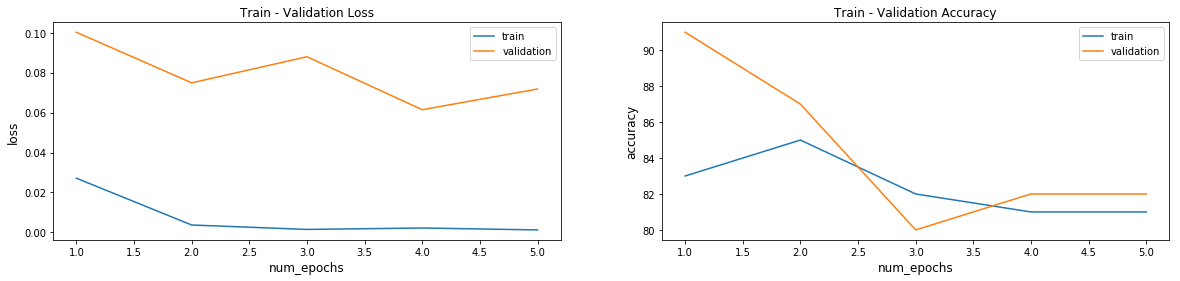

In [51]:
plot_graph(n_epochs)